In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 7
commitnumber = f17e0b2
conc = na
dv = 0.01
klin = 0
molecule = h2o
ng_adju = [0]
ng_refs = [7]
nv = 100
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 2
option_wgt_k = 1
ref_pts = [(600, 250)]
tsfc = 257
w_diffuse = [(2, 1.6, 1.6, 1.6, 1.6, 1.6, 1.8)]
wgt = [(0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

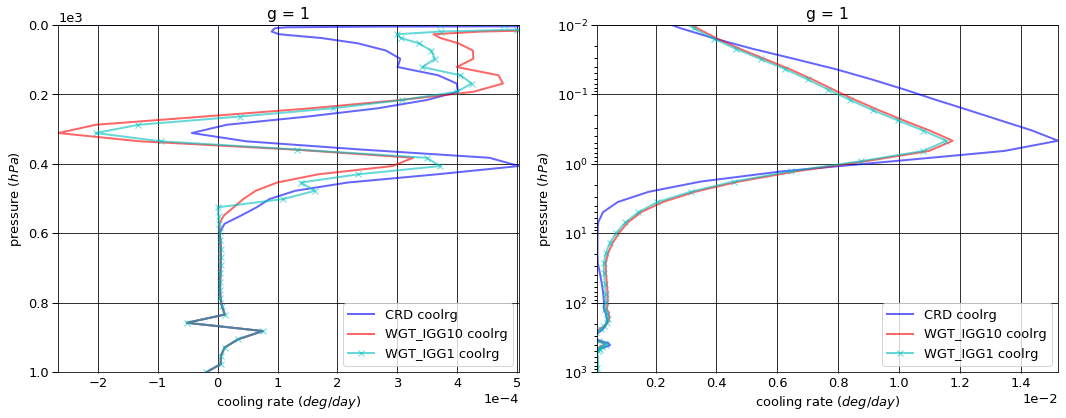

# Figure: cooling rate g-group 2

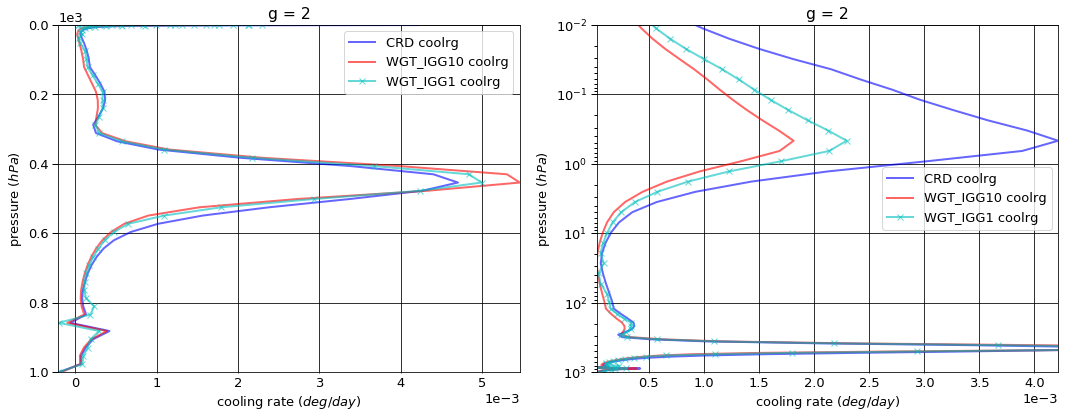

# Figure: cooling rate g-group 3

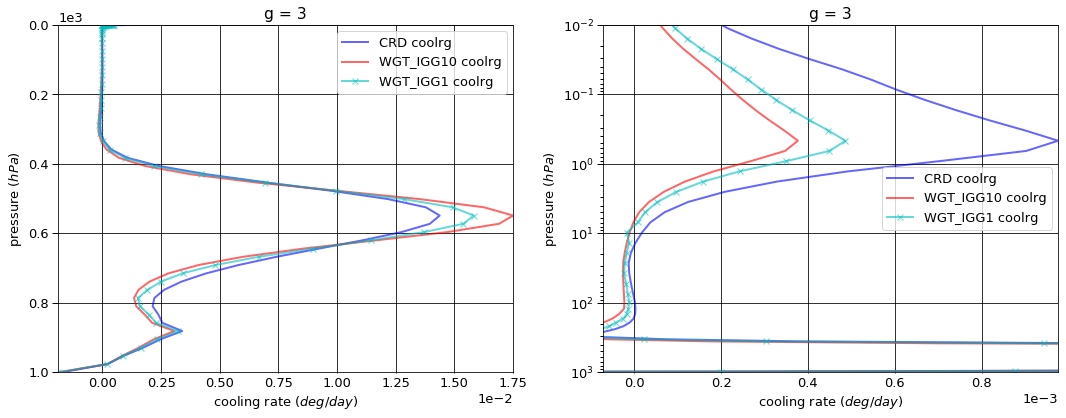

# Figure: cooling rate g-group 4

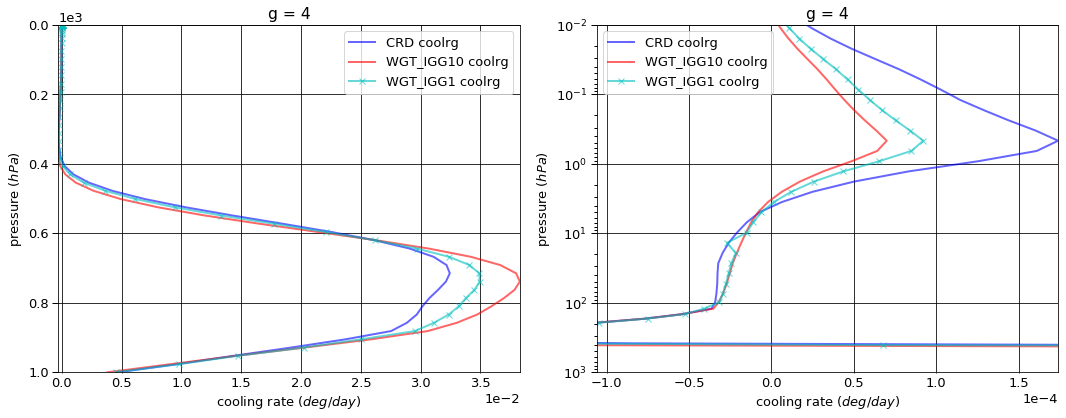

# Figure: cooling rate g-group 5

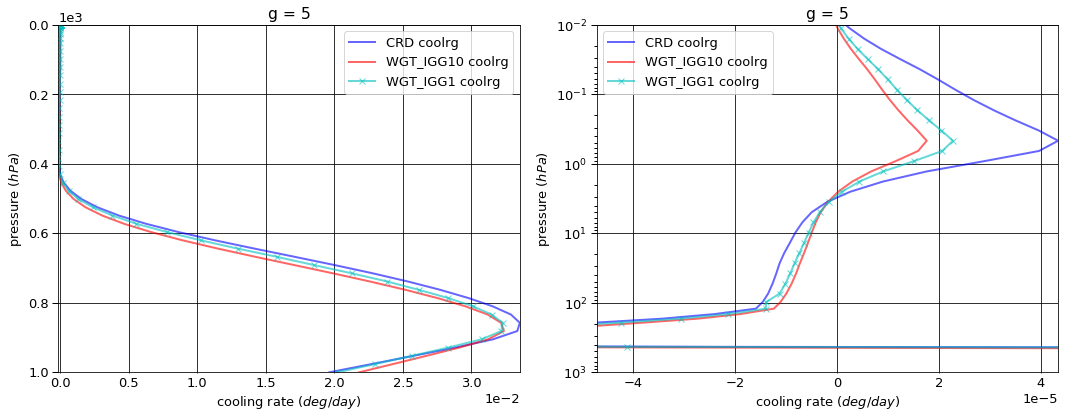

# Figure: cooling rate g-group 6

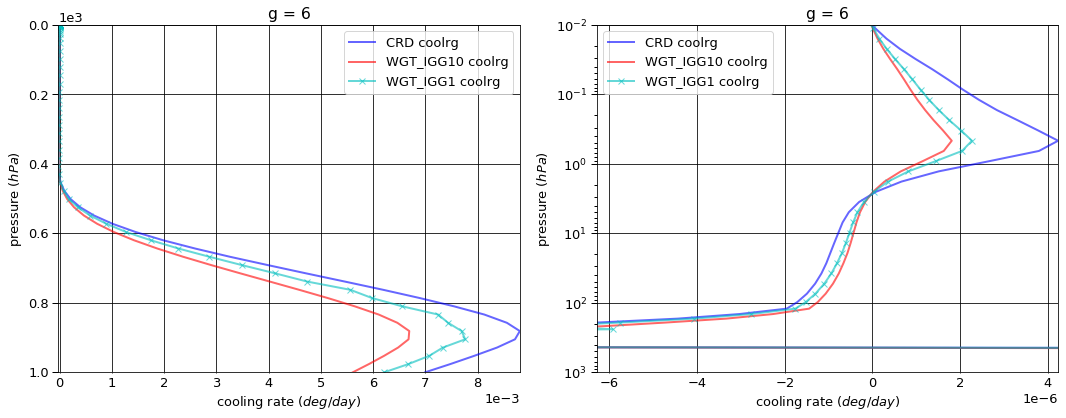

# Figure: cooling rate g-group 7

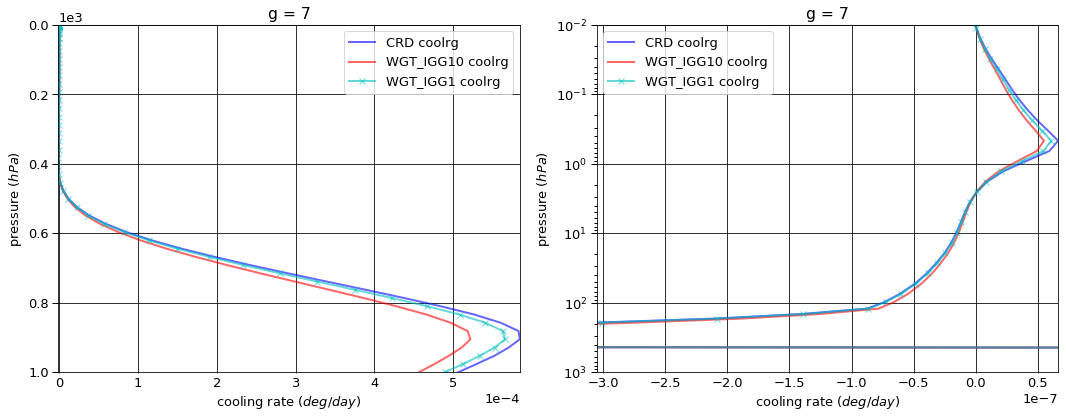

# Figure: cooling rate g-group total

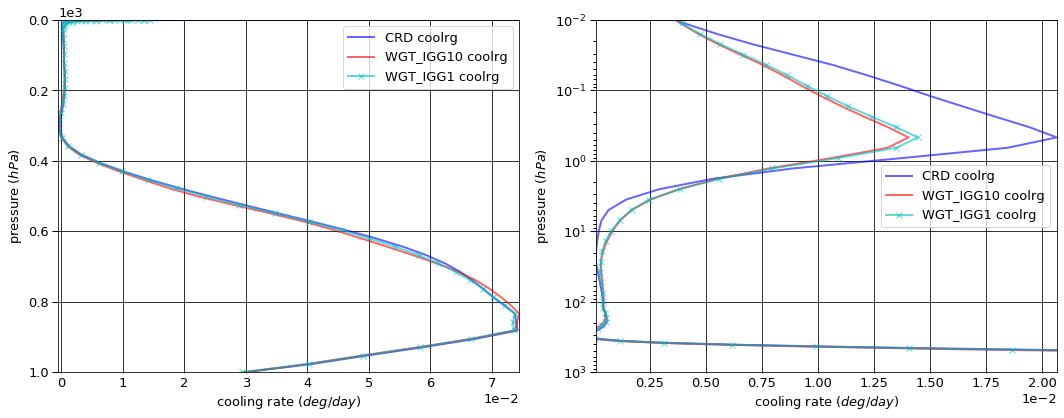

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.017712  0.000000 -0.017712
  1013.0   76    -0.064613  0.064678  0.000064
2 0.0      1     -0.099011  0.000000 -0.099011
  1013.0   76    -0.256941  0.257681  0.000740
3 0.0      1     -0.419287  0.000000 -0.419287
  1013.0   76    -0.708616  0.718054  0.009438
4 0.0      1     -1.549114  0.000000 -1.549114
  1013.0   76    -1.862858  1.754252 -0.108606
5 0.0      1     -2.709981  0.000000 -2.709981
  1013.0   76    -2.819606  1.380469 -1.439136
6 0.0      1     -2.915849  0.000000 -2.915849
  1013.0   76    -2.931133  0.328569 -2.602564
7 0.0      1     -0.913465  0.000000 -0.913465
  1013.0   76    -0.914263  0.021300 -0.892963


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.016416  0.000000 -0.016416
  1013.0   76    -0.064613  0.064678  0.000064
2 0.0      1     -0.094968  0.000000 -0.094968
  1013.0   76    -0.256941  0.257550  0.000609
3 0.0      1     -0.414874  0.000000 -0.414874
  1013.0   76    -0.708616  0.717117  0.008501
4 0.0      1     -1.566950  0.000000 -1.566950
  1013.0   76    -1.862858  1.849390 -0.013468
5 0.0      1     -2.738699  0.000000 -2.738699
  1013.0   76    -2.819606  1.268843 -1.550762
6 0.0      1     -2.920514  0.000000 -2.920514
  1013.0   76    -2.931133  0.247462 -2.683671
7 0.0      1     -0.913570  0.000000 -0.913570
  1013.0   76    -0.914263  0.018898 -0.895365


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.016632  0.000000 -0.016632
  1013.0   76    -0.064613  0.064678  0.000064
2 0.0      1     -0.095123  0.000000 -0.095123
  1013.0   76    -0.256941  0.257689  0.000748
3 0.0      1     -0.413712  0.000000 -0.413712
  1013.0   76    -0.708616  0.717694  0.009078
4 0.0      1     -1.554298  0.000000 -1.554298
  1013.0   76    -1.862858  1.812091 -0.050767
5 0.0      1     -2.721984  0.000000 -2.721984
  1013.0   76    -2.819606  1.312989 -1.506616
6 0.0      1     -2.917710  0.000000 -2.917710
  1013.0   76    -2.931133  0.289227 -2.641907
7 0.0      1     -0.913491  0.000000 -0.913491
  1013.0   76    -0.914263  0.020577 -0.893686


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      1.296536e-03  0.000000  0.001297
  1013.0   76     0.000000e+00  0.000000  0.000000
2 0.0      1      4.043511e-03  0.000000  0.004044
  1013.0   76     0.000000e+00 -0.000131 -0.000131
3 0.0      1      4.412500e-03  0.000000  0.004413
  1013.0   76     0.000000e+00 -0.000937 -0.000937
4 0.0      1     -1.783530e-02  0.000000 -0.017835
  1013.0   76     2.220446e-16  0.095138  0.095138
5 0.0      1     -2.871830e-02  0.000000 -0.028718
  1013.0   76    -4.440892e-16 -0.111626 -0.111626
6 0.0      1     -4.665300e-03  0.000000 -0.004665
  1013.0   76     0.000000e+00 -0.081107 -0.081107
7 0.0      1     -1.053200e-04  0.000000 -0.000105
  1013.0   76     1.110223e-16 -0.002402 -0.002402


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      1.080273e-03  0.000000  0.001080
  1013.0   76     0.000000e+00  0.000000  0.000000
2 0.0      1      3.888235e-03  0.000000  0.003888
  1013.0   76     0.000000e+00  0.000008  0.000008
3 0.0      1      5.574560e-03  0.000000  0.005575
  1013.0   76     0.000000e+00 -0.000359 -0.000359
4 0.0      1     -5.183900e-03  0.000000 -0.005184
  1013.0   76     2.220446e-16  0.057839  0.057839
5 0.0      1     -1.200330e-02  0.000000 -0.012003
  1013.0   76    -4.440892e-16 -0.067480 -0.067480
6 0.0      1     -1.861100e-03  0.000000 -0.001861
  1013.0   76     0.000000e+00 -0.039342 -0.039342
7 0.0      1     -2.614000e-05  0.000000 -0.000026
  1013.0   76     1.110223e-16 -0.000723 -0.000723

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.577614e-03
  1001.112500 75    -1.888954e-05
2 0.000312    1     -6.284912e-06
  1001.112500 75    -2.042062e-04
3 0.000312    1     -9.816622e-06
  1001.112500 75    -1.727723e-03
4 0.000312    1     -2.838197e-05
  1001.112500 75     4.666915e-03
5 0.000312    1     -8.881445e-06
  1001.112500 75     1.962896e-02
6 0.000312    1     -7.711995e-07
  1001.112500 75     6.995406e-03
7 0.000312    1     -7.418036e-09
  1001.112500 75     5.063866e-04


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      4.435385e-04
  1001.112500 75    -1.888954e-05
2 0.000312    1      1.106522e-05
  1001.112500 75    -1.729677e-04
3 0.000312    1     -2.292602e-05
  1001.112500 75    -1.872422e-03
4 0.000312    1     -1.650375e-05
  1001.112500 75     3.799613e-03
5 0.000312    1     -4.618641e-06
  1001.112500 75     2.180987e-02
6 0.000312    1     -3.604187e-07
  1001.112500 75     5.610775e-03
7 0.000312    1     -6.295273e-09
  1001.112500 75     4.564825e-04


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      3.705815e-04
  1001.112500 75    -1.888954e-05
2 0.000312    1      3.159236e-05
  1001.112500 75    -2.068642e-04
3 0.000312    1     -2.006601e-05
  1001.112500 75    -1.878676e-03
4 0.000312    1     -1.722401e-05
  1001.112500 75     4.498802e-03
5 0.000312    1     -5.306390e-06
  1001.112500 75     2.022470e-02
6 0.000312    1     -4.408613e-07
  1001.112500 75     6.212891e-03
7 0.000312    1     -6.954221e-09
  1001.112500 75     4.896833e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.021152e-03
  1001.112500 75    -3.388132e-21
2 0.000312    1      1.735013e-05
  1001.112500 75     3.123845e-05
3 0.000312    1     -1.310940e-05
  1001.112500 75    -1.446991e-04
4 0.000312    1      1.187821e-05
  1001.112500 75    -8.673024e-04
5 0.000312    1      4.262804e-06
  1001.112500 75     2.180918e-03
6 0.000312    1      4.107809e-07
  1001.112500 75    -1.384630e-03
7 0.000312    1      1.122762e-09
  1001.112500 75    -4.990416e-05


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.948195e-03
  1001.112500 75    -3.388132e-21
2 0.000312    1      3.787727e-05
  1001.112500 75    -2.658040e-06
3 0.000312    1     -1.024939e-05
  1001.112500 75    -1.509526e-04
4 0.000312    1      1.115795e-05
  1001.112500 75    -1.681132e-04
5 0.000312    1      3.575055e-06
  1001.112500 75     5.957430e-04
6 0.000312    1      3.303383e-07
  1001.112500 75    -7.825151e-04
7 0.000312    1      4.638149e-10
  1001.112500 75    -1.670329e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.624419,0.000000,-8.624419
1013.0,76,-9.558030,4.525003,-5.033027



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.665991,0.000000,-8.665991
1013.0,76,-9.558030,4.423938,-5.134093



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.63295,0.000000,-8.632950
1013.0,76,-9.55803,4.474945,-5.083086



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.041572,0.000000,-0.041572
1013.0,76,0.000000,-0.101065,-0.101065



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.008531,0.000000,-0.008531
1013.0,76,0.000000,-0.050058,-0.050058


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.001632
1001.112500,75,0.029847



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000410
1001.112500,75,0.029612



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.000359
1001.112500,75,0.029322



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.002042
1001.112500,75,-0.000234



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.001991
1001.112500,75,-0.000525


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.008424,0.006687
2,0.031636,0.026666
3,0.084424,0.073672
4,0.218545,0.193815
5,0.300909,0.294651
6,0.277394,0.308012
7,0.078667,0.096497


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.694881e-20
2,2.526252e-21
3,3.765425e-22
4,5.612436e-23
5,8.365440e-24
6,1.246884e-24
7,1.858504e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.694881e-20,NaN,0.008424,0.006687,0.008424,0.006687,600.0
2,2.526252e-21,0.149052,0.031636,0.026666,0.040061,0.033353,600.0
3,3.765425e-22,0.149052,0.084424,0.073672,0.124485,0.107025,600.0
4,5.612436e-23,0.149052,0.218545,0.193815,0.343030,0.300840,600.0
5,8.365440e-24,0.149052,0.300909,0.294651,0.643939,0.595491,600.0
6,1.246884e-24,0.149052,0.277394,0.308012,0.921333,0.903503,600.0
7,1.858504e-25,0.149052,0.078667,0.096497,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
